# 2-5. 프로젝트: SentencePiece 사용하기

## 필요한 모듈 import

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from konlpy.tag import Mecab
import sentencepiece as spm

from tensorflow import keras

%matplotlib inline

## 데이터 불러오기 (네이버 영화 리뷰)

In [2]:
train_data = pd.read_table('data/ratings_train.txt').dropna(how='any')
test_data = pd.read_table('data/ratings_test.txt').dropna(how='any')

# train_data.head()
print(train_data.shape)
print(test_data.shape)

X_train = []
X_test = []
y_train = []
y_test = []

(149995, 3)
(49997, 3)


In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 데이터 정제

전체 문장 수: 149995 

>> 문장의 최단 길이: 1
>> 문장의 최장 길이: 146
>> 문장의 평균 길이: 35


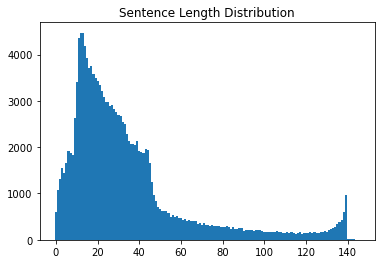

In [5]:
# 문장 길이 분포 확인
# print(train_data['document'])
min_len = 999
max_len = 0
sum_len = 0

print("전체 문장 수:", len(train_data['document']), "\n")

# for key, val in train_data.T.items(): # https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
for key, val in train_data['document'].items():
    sentence = str(val)
    
    length = len(sentence)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print(">> 문장의 최단 길이:", min_len)
print(">> 문장의 최장 길이:", max_len)
print(">> 문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for key, val in train_data['document'].items():
    sentence = str(val)
    
    sentence_length[len(sentence)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
# 특정 길이의 문장 확인

def check_sentence_with_length(column, length):
    count = 0
    
    for key, val in column.items():
        sentence = str(val)
        
        if len(sentence) == length:
            print(sentence)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [7]:
# 중복 제거: 149995 -> 146182 으로 감소폭이 비교적 작다.

print('train_data (before):', len(train_data))
print('test_data (before):', len(test_data), '\n')

train_data = train_data.drop_duplicates(subset='document', keep='last') # https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest
test_data = test_data.drop_duplicates(subset='document', keep='last')

print('train_data (after):', len(train_data))
print('test_data (after):', len(test_data))

train_data (before): 149995
test_data (before): 49997 

train_data (after): 146182
test_data (after): 49157


In [ ]:
'''
# print(train_data['document'].tolist()[:10])
sentences = list(set(train_data['document'].tolist()))

# NaN 값 제거
sentences = [x for x in sentences if not pd.isnull(x)] # https://stackoverflow.com/questions/21011777/how-can-i-remove-nan-from-list-python-numpy

print("중복 제거 후 문장 수:", len(sentences))
print(sentences[:10])
'''

In [8]:
# 길이가 5 미만인 문장은 노이즈가 될 수 있으므로 제외
# 길이가 50 이상인 문장은 메모리를 많이 차지할 수 있으므로 제외
# 길이 제한 후 문장 수: 117188

limited_min_len = 5
limited_max_len = 50

print('train_data (before):', len(train_data))
print('test_data (before):', len(test_data), '\n')

# https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
train_data = train_data[train_data['document'].map(len) >= limited_min_len] 
train_data = train_data[train_data['document'].map(len) < limited_max_len]

test_data = test_data[test_data['document'].map(len) >= limited_min_len] 
test_data = test_data[test_data['document'].map(len) < limited_max_len]

print('train_data (after):', len(train_data))
print('test_data (after):', len(test_data))

train_data (before): 146182
test_data (before): 49157 

train_data (after): 117188
test_data (after): 39288


In [ ]:
'''
limited_sentences = [s for s in sentences if (len(s) < limited_max_len) & (len(s) >= limited_min_len)]

print("길이 제한 후 문장 수:", len(limited_sentences))

limited_sentence_length = np.zeros((limited_max_len), dtype=np.int)

for sentence in limited_sentences:
    limited_sentence_length[len(sentence)-1] += 1

plt.bar(range(limited_max_len), limited_sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()
'''

In [9]:
X_train = train_data['document'].tolist()
y_train = train_data['label']

X_test = test_data['document'].tolist()
y_test = test_data['label']

## SentencePiece 모델 학습

In [10]:
temp_file = 'data/naver_rating.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in X_train:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_naver_rating --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_naver_rating*

-rw-r--r-- 1 aiffel0042 aiffel0042 375521 10월 15 21:35 korean_spm_naver_rating.model
-rw-r--r-- 1 aiffel0042 aiffel0042 144986 10월 15 21:35 korean_spm_naver_rating.vocab


In [11]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_naver_rating.model')

True

In [12]:
# 테스트

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1702, 10, 392, 16, 1420, 10, 155, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## SentencePiece tokenizer 함수 작성

In [13]:
def sp_tokenize(s, corpus):
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_naver_rating.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

# 테스트
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 499 2944   14 1122 2354    4    0    0    0    0]
 [1427 2065  239  513   10    3   17 7905  765    8]]


In [14]:
train_tensor, train_word_index, train_index_word = sp_tokenize(s, X_train)
test_tensor, test_word_index, test_index_word = sp_tokenize(s, X_test)

In [15]:
print(train_tensor.shape)
print(y_train.shape, '\n')
print(test_tensor.shape)
print(y_test.shape)

(117188, 42)
(117188,) 

(39288, 48)
(39288,)


## 모델 만들기

In [16]:
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          6272      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 134,305
Trainable params: 134,305
Non-trainable params: 0
_________________________________________________________________


## validation data 분리

In [17]:
# 10000건

X_val = train_tensor[:10000]
y_val = y_train[:10000]

X_train_divided = train_tensor[10000:]
y_train_divided = y_train[10000:]

print(X_train_divided.shape)
print(y_train_divided.shape, '\n')
print(X_val.shape)
print(y_val.shape)

(107188, 42)
(107188,) 

(10000, 42)
(10000,)


## 모델 학습

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_divided,
                    y_train_divided,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
210/210 [==============================] - 1s 5ms/step - loss: 0.5306 - accuracy: 0.7334 - val_loss: 0.4071 - val_accuracy: 0.8186
Epoch 2/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3881 - accuracy: 0.8293 - val_loss: 0.3864 - val_accuracy: 0.8249
Epoch 3/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3663 - accuracy: 0.8370 - val_loss: 0.3809 - val_accuracy: 0.8253
Epoch 4/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3577 - accuracy: 0.8406 - val_loss: 0.3846 - val_accuracy: 0.8198
Epoch 5/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3512 - accuracy: 0.8424 - val_loss: 0.3757 - val_accuracy: 0.8276
Epoch 6/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3451 - accuracy: 0.8440 - val_loss: 0.3770 - val_accuracy: 0.8268
Epoch 7/10
210/210 [==============================] - 1s 4ms/step - loss: 0.3376 - accuracy: 0.8460 - val_loss: 0.3773 - val_accuracy: 0.8261
Epoch 

## 결과 확인 및 시각화

* accuracy: 0.8215 (> 80%)

In [19]:
model.evaluate(test_tensor, y_test, verbose=2)

1228/1228 - 2s - loss: 0.4025 - accuracy: 0.8215


[0.40249380469322205, 0.8214894533157349]

In [20]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


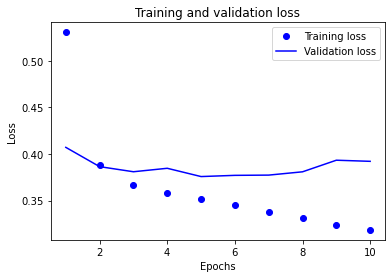

In [21]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

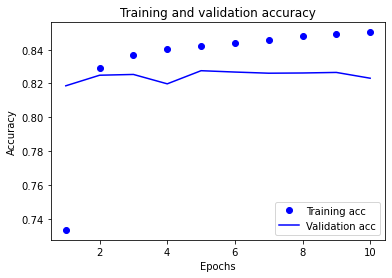

In [22]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()